<a href="https://colab.research.google.com/github/shivammehta007/QuestionGenerator/blob/master/Classifier_to_detect_type_of_questions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Testing Classifier Model

In [1]:
# Essential Installation for working of notebook
!pip install -U tqdm

Requirement already up-to-date: tqdm in /usr/local/lib/python3.6/dist-packages (4.44.1)


### Imports

In [0]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spacy
import seaborn as sns
import torch
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from tqdm.auto import tqdm, trange
from wordcloud import WordCloud
from xgboost import XGBClassifier

### Environment Setup 

In [0]:
SEED=1234
def seed_all(seed=1234):
    """Seed the results for duplication"""
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_all(SEED)

In [0]:
tqdm.pandas()
nlp = spacy.load("en_core_web_sm") 

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
DATASET_LOCATION = '/content/drive/My Drive/Data/GrammarDataset.csv'

## Dataset Overview

In [0]:
original_dataset = pd.read_csv(DATASET_LOCATION, sep="\t")

In [8]:
original_dataset.head()

,Question,key,answer,Type of Question,Sub Section
0,She _________________ some chocolates to the p...,bring,She brought some chocolates to the party.,irregular verb,past simple
1,I _________________ a new song on the radio.,hear,I heard a new song on the radio.,irregular verb,past simple
2,I _________________ three books last week.,read,I read three books last week.,irregular verb,past simple
3,They _________________ French to the waitress.,speak,They spoke French to the waitress.,irregular verb,past simple
4,He _________________ during the class but now ...,understand,He understood during the class but now he doe...,irregular verb,past simple


In [9]:
original_dataset.dtypes

Question            object
key                 object
answer              object
Type of Question    object
Sub Section         object
dtype: object

#### EDA

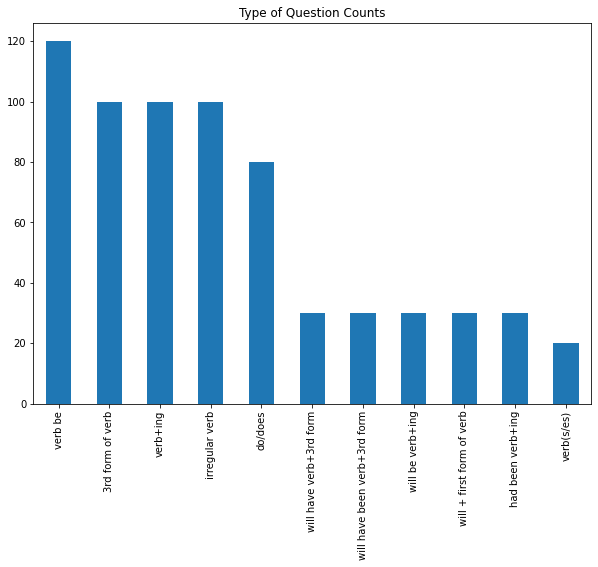

In [10]:
ax, fig = plt.subplots(figsize=(10, 7))
question_class = original_dataset["Type of Question"].value_counts()
question_class.plot(kind='bar')
plt.title('Type of Question Counts')
plt.show()

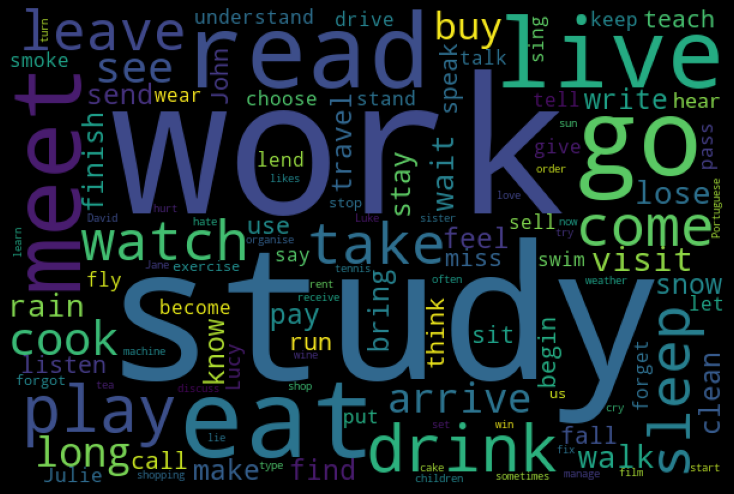

In [11]:
insincere_wordcloud = WordCloud(width=600, height=400).generate(" ".join(original_dataset["key"]))
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(insincere_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

### PreProcessing

In [0]:
def preprocessor(dataset):
    # Replace continuous underscores with single one
    dataset["Question"] = dataset["Question"].str.replace("[_]{2,}", "_")
    # Remove Brackets
    dataset["Question"] = dataset["Question"].str.replace("[\)\(]", "")
    # Strip whitespaces
    dataset["Question"] = dataset["Question"].apply(lambda x: x.strip())
    # Convert all text to lowercase
    for columns in dataset.columns:
        dataset[columns] = dataset[columns].str.lower() 

    return dataset

In [0]:
original_dataset = preprocessor(original_dataset)

In [14]:
original_dataset.columns

Index(['Question', 'key', 'answer', 'Type of Question', 'Sub Section'], dtype='object')

#### Encoding Labels

In [0]:
label_encoder = LabelEncoder()
original_dataset["Type of Question"] = label_encoder.fit_transform(original_dataset["Type of Question"])

#### Split Training and Testing Data

In [0]:
X_train_orig_dataset, X_test_orig_dataset, y_train_orig_dataset, y_test_orig_dataset = train_test_split(original_dataset[["Question", "key", "answer"]], original_dataset["Type of Question"], random_state=SEED, test_size=0.15)

In [17]:
X_train_orig_dataset.shape, X_test_orig_dataset.shape, y_train_orig_dataset.shape, y_test_orig_dataset.shape

((569, 3), (101, 3), (569,), (101,))

## Experiments:

In [18]:
X_train_orig_dataset.head()

,Question,key,answer
271,how / they / get to work?,they,how do they get to work?
488,we were late for the plane because we _our pas...,forgot,we were late for the plane because we had forg...
131,we _ thirsty.,be,we aren't thirsty.
643,"he_, so the kitchen will be warm.",cook,"he will have been cooking, so the kitchen will..."
155,you / in a cafe?,be,are you in a cafe?


### Experimentation Setup

#### Models

In [0]:
text_vectorizers = [
                    ('CountVectorizer', CountVectorizer(tokenizer=lambda x: x.split())), 
                    ('TfIdFVectorize', TfidfVectorizer(tokenizer=lambda x: x.split()))
                ]
classifiers = [
               ('MultiNomial Naive Bais', MultinomialNB(alpha=0.1)),
               ('LogisticRegression', LogisticRegression(max_iter=5000)), 
               ('SVM', SVC()), ('RandomForest', RandomForestClassifier()), 
               ('XGBClassifier', XGBClassifier(random_state=SEED, learning_rate=0.01))
            ]

In [0]:
def check_classification(X_train, y_train, X_test, y_test):

    # Result DataFrame
    result_dataframe = pd.DataFrame({
        'Vectorizer': [name for name, model in text_vectorizers]
        }, columns = ['Vectorizer'] + [name for name, model in classifiers])
    result_dataframe.set_index('Vectorizer', inplace=True)


    best_score = 0
    best_model = None
    best_pipe = None
    for classifier_name, classifier in classifiers:
        for text_vectorizer_name, text_vectorizer in text_vectorizers:
            pipe = Pipeline(steps=[
                                ('text_vec', text_vectorizer),
                                ('class', classifier)
            ])
            pipe.fit(X_train, y_train)
            f1_measure = f1_score(pipe.predict(X_test), y_test, average='micro')
            # print('Model : {} -> {}:  accuracy: {:.4f}'.format(text_vectorizer_name, classifier_name, acc*100))
            result_dataframe[classifier_name][text_vectorizer_name] = '{:.4f}'.format(f1_measure)

            if f1_measure > best_score:
                best_score = f1_measure
                best_pipe = pipe
                best_model = '{} -> {}'.format(text_vectorizer_name, classifier_name)
    # TODO: Remove while actually writing the code Code for Debugging
    # analyzer = best_pipe['text_vec'].build_analyzer()
    # print(analyzer("i _ the steak for dinner.  choose  i chose the steak for dinner."))
    # print(analyzer("words#i _ words#_ words#the words#steak words#for words#dinner words#. words#  words#choose words#  words#i words#chose words#the words#steak words#for words#dinner words#."))
    # with np.printoptions(threshold=np.inf):
    #     print("First: {}".format(best_pipe['text_vec'].transform(["i _ the steak for dinner.  choose  i chose the steak for dinner."])[0]))
    #     print("Second: {}".format(best_pipe['text_vec'].transform(["words#i words#_ words#the words#steak words#for words#dinner words#. words#  words#choose words#  words#i words#chose words#the words#steak words#for words#dinner words#."])[0]))


    print("\n\nBest F1 Measure was: {:.4f} with the Model: {}".format(best_score, best_model))
    return result_dataframe

#### Result Placeholder

In [0]:
result_dataframe = pd.DataFrame({
        'Vectorizer': [name for name, model in text_vectorizers]
        }, columns = ['Vectorizer'] + [name for name, model in classifiers])
result_dataframe.set_index('Vectorizer', inplace=True)

results = []

#### N-Gram Generator

In [0]:
from itertools import cycle
from collections import deque

def ngrams(sentence, n=2):
    words = [word.text for word in nlp(sentence)]
    d = deque(maxlen=n)
    d.extend(words[:n])
    words = words[n:]
    results = []
    for window, word in zip(cycle((d,)), words):
        results.extend([ngram for ngram in window])
        d.append(word)
    results.extend([ngram for ngram in d])

    return results


In [23]:
for n in range(2,5):
    print(" {}-Grams:".format(n), end=" ")
    print(ngrams("Hello World! This is a test example of N-Gram generator", n))

 2-Grams: ['Hello', 'World', 'World', '!', '!', 'This', 'This', 'is', 'is', 'a', 'a', 'test', 'test', 'example', 'example', 'of', 'of', 'N', 'N', '-', '-', 'Gram', 'Gram', 'generator']
 3-Grams: ['Hello', 'World', '!', 'World', '!', 'This', '!', 'This', 'is', 'This', 'is', 'a', 'is', 'a', 'test', 'a', 'test', 'example', 'test', 'example', 'of', 'example', 'of', 'N', 'of', 'N', '-', 'N', '-', 'Gram', '-', 'Gram', 'generator']
 4-Grams: ['Hello', 'World', '!', 'This', 'World', '!', 'This', 'is', '!', 'This', 'is', 'a', 'This', 'is', 'a', 'test', 'is', 'a', 'test', 'example', 'a', 'test', 'example', 'of', 'test', 'example', 'of', 'N', 'example', 'of', 'N', '-', 'of', 'N', '-', 'Gram', 'N', '-', 'Gram', 'generator']


#### Sample Generator

In [0]:
def get_input_samples(X, y, n=5):
    results = []
    for i in random.sample(range(len(X) - 1), n):
        results.append("{} --> {} ".format(X.iloc[i], label_encoder.inverse_transform([y.iloc[i]])))

    return results

### Experiment 1:  Word#\$\{$words_i$\}
Concatenating Question + key + answer in a Bag Of Words Approach \\
No Feature Engineering

In [0]:
experiment_text = "Concatenating question + key + answer. like word#word_i"

#### Preprocessing

In [0]:
X_train = X_train_orig_dataset["Question"] + " " + X_train_orig_dataset["key"] + " " + X_train_orig_dataset["answer"]
y_train = y_train_orig_dataset
X_test = X_test_orig_dataset["Question"] + " " + X_test_orig_dataset["key"] + " " + X_test_orig_dataset["answer"]
y_test = y_test_orig_dataset

In [27]:
def add_word_template(text):
    tokens = nlp(text)
    text = []
    for token in tokens:
        text.append("words#{}".format(token.text))

    return " ".join(text)

add_template_words("i _ the steak for dinner.  choose  i chose the steak for dinner.")

'words#i words#_ words#the words#steak words#for words#dinner words#. words#  words#choose words#  words#i words#chose words#the words#steak words#for words#dinner words#.'

In [28]:
X_train = X_train.progress_apply(add_word_template)
X_test = X_test.progress_apply(add_word_template)

#### Input Samples

In [29]:
get_input_samples(X_train, y_train)

["words#they words#_ words#so words#we words#went words#to words#a words#restaurant words#. words#not words#eat words#they words#had words#n't words#eaten words#so words#we words#went words#to words#a words#restaurant words#. --> ['3rd form of verb'] ",
 "words#when words#/ words#you words#/ words#leave words#? words#you words#leave words#when words#are words#you words#leaving words#? --> ['verb+ing'] ",
 "words#they words#/ words#live words#in words#london words#live words#they words#live words#in words#london words#. --> ['verb(s/es)'] ",
 "words#_ words#football words#when words#he words#was words#injured words#? words#how words#long words#he words#play words#how words#long words#had words#he words#been words#playing words#football words#when words#he words#was words#injured words#? --> ['had been verb+ing'] ",
 "words#_ words#the words#film words#already words#? words#she words#see words#had words#she words#seen words#the words#film words#already words#? --> ['3rd form of verb'] "]

#### Experimentation Results

In [30]:
result = check_classification(X_train, y_train, X_test, y_test)
results.append((experiment_text, result))
result

# First:   (0, 24)	1
#   (0, 193)	1
#   (0, 194)	1
#   (0, 257)	2
#   (0, 356)	2
#   (0, 447)	2
#   (0, 851)	2
#   (0, 912)	2
# Second:   (0, 24)



Best F1 Measure was: 0.9703 with the Model: CountVectorizer -> RandomForest


,MultiNomial Naive Bais,LogisticRegression,SVM,RandomForest,XGBClassifier
Vectorizer,,,,,
CountVectorizer,0.7327,0.8812,0.7822,0.9703,0.9703
TfIdFVectorize,0.6832,0.7228,0.6733,0.9307,0.9406


### Experiment 2: word_pos#\$\{$word_i$\}_\$\{$pos_i$\}
With Word and POS tags, token.tag_ gives a detailed POS tag where we can distinguish between forms of verb. \\
More Information https://spacy.io/api/annotation#pos-tagging about the tags

In [0]:
experiment_text = "Adding Pos Tags along with word word_pos#{word_i}_{pos_i} + k#tags + a#tags Unigrams"

#### Preprocessing

In [0]:
X_train = X_train_orig_dataset["Question"] + " " + X_train_orig_dataset["key"] + " " + X_train_orig_dataset["answer"]
y_train = y_train_orig_dataset
X_test = X_test_orig_dataset["Question"] + " " + X_test_orig_dataset["key"] + " " + X_test_orig_dataset["answer"]
y_test = y_test_orig_dataset

In [81]:
def add_word_pos_template(text):
    tokens = nlp(text)
    text = []
    for token in tokens:
        text.append("word_pos#{}_{}".format(token.text, token.tag_))

    return " ".join(text)

# Testing method
test_sentence = "Testing the Pos Tagger in this sentence let's see how it works!".lower()
add_pos_tagging(test_sentence)

'pos#VERB pos#DET pos#NOUN pos#NOUN pos#ADP pos#DET pos#NOUN pos#VERB pos#PRON pos#VERB pos#ADV pos#PRON pos#VERB pos#PUNCT'

In [82]:
X_train = X_train.progress_apply(add_word_pos_template)
X_test = X_test.progress_apply(add_word_pos_template)

#### Input Samples

In [83]:
get_input_samples(X_train, y_train)

["word_pos#the_DT word_pos#garden_NN word_pos#was_VBD word_pos#dead_JJ word_pos#because_IN word_pos#it_PRP word_pos#__NNP word_pos#dry_JJ word_pos#all_DT word_pos#summer_NN word_pos#._. word_pos#be_VB word_pos#the_DT word_pos#garden_NN word_pos#was_VBD word_pos#dead_JJ word_pos#because_IN word_pos#it_PRP word_pos#had_VBD word_pos#been_VBN word_pos#dry_JJ word_pos#all_DT word_pos#summer_NN word_pos#._. --> ['3rd form of verb'] ",
 "word_pos#__NNP word_pos#by_IN word_pos#friday_NNP word_pos#?_. word_pos#she_PRP word_pos#arrive_VBP word_pos#will_MD word_pos#she_PRP word_pos#have_VBP word_pos#arrived_VBN word_pos#by_IN word_pos#friday_NNP word_pos#?_. --> ['will have verb+3rd form'] ",
 "word_pos#__IN word_pos#my_PRP$ word_pos#parents_NNS word_pos#already_RB word_pos#that_DT word_pos#winter_NN word_pos#?_. word_pos#we_PRP word_pos#visit_VBP word_pos#had_VBD word_pos#we_PRP word_pos#visited_VBN word_pos#my_PRP$ word_pos#parents_NNS word_pos#already_RB word_pos#that_DT word_pos#winter_NN wor

#### Experimentation Results

In [84]:
result = check_classification(X_train, y_train, X_test, y_test)
results.append((experiment_text, result))
result



Best F1 Measure was: 0.9604 with the Model: CountVectorizer -> RandomForest


,MultiNomial Naive Bais,LogisticRegression,SVM,RandomForest,XGBClassifier
Vectorizer,,,,,
CountVectorizer,0.7228,0.8614,0.7525,0.9604,0.9406
TfIdFVectorize,0.6733,0.7327,0.7129,0.8812,0.8812


### Experiment 3: pos#\$\{$pos_i$\} 
With just POS

In [0]:
experiment_text = "Classifying based on POS tags pos#{pos_i}"

#### Preprocessing

In [0]:
X_train = X_train_orig_dataset["Question"] + " " + X_train_orig_dataset["key"] + " " + X_train_orig_dataset["answer"]
y_train = y_train_orig_dataset
X_test = X_test_orig_dataset["Question"] + " " + X_test_orig_dataset["key"] + " " + X_test_orig_dataset["answer"]
y_test = y_test_orig_dataset

In [75]:
def add_pos_template(text):
    tokens = nlp(text)
    text = []
    for token in tokens:
        text.append("pos#{}".format(token.tag_))

    return " ".join(text)

# Testing method
test_sentence = "Testing the Pos Tagger in this sentence let's see how it works!".lower()
add_pos_template(test_sentence)

'pos#VBG pos#DT pos#NN pos#NN pos#IN pos#DT pos#NN pos#VB pos#PRP pos#VB pos#WRB pos#PRP pos#VBZ pos#.'

In [76]:
X_train = X_train.progress_apply(add_pos_template)
X_test = X_test.progress_apply(add_pos_template)

#### Input Samples

In [77]:
get_input_samples(X_train, y_train)

["pos#PRP pos#: pos#RB pos#SYM pos#VB pos#DT pos#NN pos#RB pos#VB pos#PRP pos#VBP pos#RB pos#VBG pos#DT pos#NN pos#. --> ['verb+ing'] ",
 "pos#PRP pos#VBD pos#RP pos#IN pos#CD pos#NNS pos#WRB pos#PRP pos#VBD pos#JJ pos#. pos#VB pos#PRP pos#VBD pos#VBN pos#VBG pos#RP pos#IN pos#CD pos#NNS pos#WRB pos#PRP pos#VBD pos#VBN pos#. --> ['had been verb+ing'] ",
 "pos#PRP pos#SYM pos#VB pos#NN pos#IN pos#CD pos#NN pos#NN pos#PRP pos#VBD pos#VBG pos#NN pos#. --> ['verb+ing'] ",
 "pos#WDT pos#NNP pos#SYM pos#NNP pos#, pos#JJ pos#. pos#_SP pos#NNP pos#_SP pos#WDT pos#NNS pos#VBZ pos#NN pos#VB pos#. --> ['do/does'] ",
 "pos#PRP pos#VBP pos#PRP$ pos#NN pos#DT pos#NNP pos#IN pos#NNP pos#. pos#_SP pos#VB pos#_SP pos#PRP pos#VBD pos#PRP$ pos#NN pos#DT pos#NNP pos#IN pos#NNP pos#. --> ['irregular verb'] "]

#### Experimentation Results

In [78]:
result = check_classification(X_train, y_train, X_test, y_test)
results.append((experiment_text, result))
result



Best F1 Measure was: 0.9208 with the Model: CountVectorizer -> RandomForest


,MultiNomial Naive Bais,LogisticRegression,SVM,RandomForest,XGBClassifier
Vectorizer,,,,,
CountVectorizer,0.6238,0.8218,0.7624,0.9208,0.8713
TfIdFVectorize,0.6634,0.6832,0.7129,0.8911,0.7822


### Experiment 4: word\_tag#\${$word_i$}_\${$( q, k, a )$}
With Question, Key, Answer Tagging

In [0]:
experiment_text = "Tagging word with q, k, a example: word_tag#{word_i}_{q/k/a}"

#### Preprocessing

In [92]:
def add_word_tag_template(text, tag):
    tokens = nlp(text)
    text = []
    for token in tokens:
        text.append("word_tag#{}_{}".format(token.text, tag))
    
    return " ".join(text)

add_word_tag_template("test sentence", "q")

'word_tag#test_q word_tag#sentence_q'

In [0]:
X_train = X_train_orig_dataset["Question"].apply(lambda x: add_word_tag_template(x, "q")) + " " + X_train_orig_dataset["key"].apply(lambda x: add_word_tag_template(x, "k")) + " " + X_train_orig_dataset["answer"].apply(lambda x: add_word_tag_template(x, "a"))
y_train = y_train_orig_dataset
X_test = X_test_orig_dataset["Question"].apply(lambda x: add_word_tag_template(x, "q")) + " " + X_test_orig_dataset["key"].apply(lambda x: add_word_tag_template(x, "k")) + " " + X_test_orig_dataset["answer"].apply(lambda x: add_word_tag_template(x, "a"))
y_test = y_test_orig_dataset

#### Input Samples

In [94]:
get_input_samples(X_train, y_train)

["word_tag#the_q word_tag#garden_q word_tag#was_q word_tag#dead_q word_tag#because_q word_tag#it_q word_tag#__q word_tag#dry_q word_tag#all_q word_tag#summer_q word_tag#._q word_tag#be_k word_tag#the_a word_tag#garden_a word_tag#was_a word_tag#dead_a word_tag#because_a word_tag#it_a word_tag#had_a word_tag#been_a word_tag#dry_a word_tag#all_a word_tag#summer_a word_tag#._a --> ['3rd form of verb'] ",
 "word_tag#10_q word_tag#._q word_tag#what_q word_tag#/_q word_tag#you_q word_tag#/_q word_tag#think_q word_tag#?_q word_tag#you_k word_tag#think_k word_tag#what_a word_tag#are_a word_tag#you_a word_tag#thinking_a word_tag#?_a --> ['verb+ing'] ",
 "word_tag#who_q word_tag#/_q word_tag#the_q word_tag#teacher_q word_tag#/_q word_tag#be_q word_tag#?_q word_tag#be_k word_tag#who_a word_tag#was_a word_tag#the_a word_tag#teacher_a word_tag#?_a --> ['verb be'] ",
 "word_tag#8_q word_tag#._q word_tag#he_q word_tag#did_q word_tag#n't_q word_tag#feel_q word_tag#healthy_q word_tag#,_q word_tag#becaus

#### Experimentation Results

In [95]:
result = check_classification(X_train, y_train, X_test, y_test)
results.append((experiment_text, result))
result



Best F1 Measure was: 0.9802 with the Model: CountVectorizer -> XGBClassifier


,MultiNomial Naive Bais,LogisticRegression,SVM,RandomForest,XGBClassifier
Vectorizer,,,,,
CountVectorizer,0.8119,0.9505,0.8812,0.9307,0.9802
TfIdFVectorize,0.7525,0.8713,0.8317,0.9010,0.9505


### Experiment 4: word_pos_tag#\${$word_i$}_\${$pos_i$}_{(q, k, a)}
POS Tagger with q,k,a tagging

In [0]:
experiment_text = "Adding POS Tagging and qka tagging example: word_pos_tag#{word_i}_{pos_i}_{(q, k, a)}"

#### Preprocessing

In [99]:
def add_word_pos_tag_template(text, tag):
    tokens = nlp(text)
    text = []
    for token in tokens:
        text.append("word_pos_tag#{}_{}_{}".format(token.text, token.tag_, tag))

    return " ".join(text)

add_word_pos_tag_template("this is test example", "a")

'word_pos_tag#this_DT_a word_pos_tag#is_VBZ_a word_pos_tag#test_NN_a word_pos_tag#example_NN_a'

In [0]:
X_train = X_train_orig_dataset["Question"].apply(lambda x: add_word_pos_tag_template(x, "q")) + " " + X_train_orig_dataset["key"].apply(lambda x: add_word_pos_tag_template(x, "k")) + " " + X_train_orig_dataset["answer"].apply(lambda x: add_word_pos_tag_template(x, "a"))
y_train = y_train_orig_dataset
X_test = X_test_orig_dataset["Question"].apply(lambda x: add_word_pos_tag_template(x, "q")) + " " + X_test_orig_dataset["key"].apply(lambda x: add_word_pos_tag_template(x, "k")) + " " + X_test_orig_dataset["answer"].apply(lambda x: add_word_pos_tag_template(x, "a"))
y_test = y_test_orig_dataset

#### Input Samples

In [101]:
get_input_samples(X_train, y_train)

["word_pos_tag#you_PRP_q word_pos_tag#/_SYM_q word_pos_tag#drink_VB_q word_pos_tag#/_SYM_q word_pos_tag#wine_NN_q word_pos_tag#drink_VB_k word_pos_tag#wine_NN_k word_pos_tag#are_VBP_a word_pos_tag#you_PRP_a word_pos_tag#drinking_VBG_a word_pos_tag#wine_NN_a word_pos_tag#?_._a --> ['verb+ing'] ",
 "word_pos_tag#this_DT_q word_pos_tag#was_VBD_q word_pos_tag#the_DT_q word_pos_tag#first_JJ_q word_pos_tag#time_NN_q word_pos_tag#she_PRP_q word_pos_tag#had_VBD_q word_pos_tag#__NNP_q word_pos_tag#her_PRP$_q word_pos_tag#homework_NN_q word_pos_tag#do_VBP_k word_pos_tag#this_DT_a word_pos_tag#was_VBD_a word_pos_tag#the_DT_a word_pos_tag#first_JJ_a word_pos_tag#time_NN_a word_pos_tag#she_PRP_a word_pos_tag#had_VBD_a word_pos_tag#done_VBN_a word_pos_tag#her_PRP$_a word_pos_tag#homework_NN_a --> ['irregular verb'] ",
 "word_pos_tag#i_PRP_q word_pos_tag#__VBP_q word_pos_tag#some_DT_q word_pos_tag#books_NNS_q word_pos_tag#this_DT_q word_pos_tag#morning_NN_q word_pos_tag#._._q word_pos_tag#buy_VB_k wo

#### Experimentation Results

In [102]:
result = check_classification(X_train, y_train, X_test, y_test)
results.append((experiment_text, result))
result



Best F1 Measure was: 0.9307 with the Model: CountVectorizer -> LogisticRegression


,MultiNomial Naive Bais,LogisticRegression,SVM,RandomForest,XGBClassifier
Vectorizer,,,,,
CountVectorizer,0.8119,0.9307,0.8614,0.9109,0.9307
TfIdFVectorize,0.7822,0.8416,0.8218,0.8515,0.9307


### Experiment 5: Word#DetailedPOS

More Information https://spacy.io/api/annotation#pos-tagging about the tags

In [0]:
experiment_text = "Adding POS Tagging with details like Verb Forms example: word#VBG word#VBZ with same convention"

#### Preprocessing

In [54]:
def add_detailed_postag(text):
    tokens = nlp(text)
    text = []
    for token in tokens:
        text.append("{}#{}".format(token.text, token.tag_))

    return " ".join(text)

add_detailed_postag("This is a test sentence! We will see the difference between playing and played")

'This#DT is#VBZ a#DT test#NN sentence#NN !#. We#PRP will#MD see#VB the#DT difference#NN between#IN playing#VBG and#CC played#VBD'

In [0]:
X_train = X_train_orig_dataset["Question"].apply(lambda x: add_detailed_postag(x)) + " " + X_train_orig_dataset["key"].apply(lambda x: add_detailed_postag(x)) + " " + X_train_orig_dataset["answer"].apply(lambda x: add_detailed_postag(x))
y_train = y_train_orig_dataset
X_test = X_test_orig_dataset["Question"].apply(lambda x: add_detailed_postag(x)) + " " + X_test_orig_dataset["key"].apply(lambda x: add_detailed_postag(x)) + " " + X_test_orig_dataset["answer"].apply(lambda x: add_detailed_postag(x))
y_test = y_test_orig_dataset

#### Input Samples

In [56]:
get_input_samples(X_train, y_train)

["i#PRP _#NNP a#DT new#JJ song#NN on#IN the#DT radio#NN .#.  #_SP hear#NNP  #_SP i#PRP heard#VBD a#DT new#JJ song#NN on#IN the#DT radio#NN .#. --> ['irregular verb'] ",
 "i#PRP 'd#MD _#NNP a#DT lovely#JJ new#JJ bike#NN for#IN my#PRP$ birthday#NN ,#, so#CC i#PRP was#VBD keen#JJ to#TO try#VB it#PRP .#. get#VB i#PRP 'd#MD got#VBN a#DT lovely#JJ new#JJ bike#NN for#IN my#PRP$ birthday#NN ,#, so#CC i#PRP was#VBD keen#JJ to#TO try#VB it#PRP .#. --> ['irregular verb'] ",
 "why#WRB have#VBP you#PRP _#NNP up#RP ?#. are#VBP we#PRP leaving#VBG ?#. stand#VB why#WRB have#VBP you#PRP stood#VBN up#RP ?#. are#VBP we#PRP leaving#VBG ?#. --> ['irregular verb'] ",
 "he#PRP had#VBD _#NNP 6#CD miles#NNS when#WRB he#PRP hurt#VBD his#PRP$ ankle#NN .#. run#VB he#PRP had#VBD run#VBN 6#CD miles#NNS when#WRB he#PRP hurt#VBD his#PRP$ ankle#NN .#. --> ['irregular verb'] ",
 "you#PRP _#NNP a#DT doctor#NN .#. be#VB you#PRP are#VBP a#DT doctor#NN .#. --> ['verb be'] "]

#### Experimentation Results

In [57]:
result = check_classification(X_train, y_train, X_test, y_test)
results.append((experiment_text, result))
result



Best F1 Measure was: 0.9307 with the Model: CountVectorizer -> RandomForest


,MultiNomial Naive Bais,LogisticRegression,SVM,RandomForest,XGBClassifier
Vectorizer,,,,,
CountVectorizer,0.7228,0.8614,0.7228,0.9307,0.9307
TfIdFVectorize,0.6535,0.7327,0.7426,0.8911,0.8614


### Experiment 6: Word Word#DetailedPOS Word#DetailedPOS#key tagging

More Information https://spacy.io/api/annotation#pos-tagging about the tags

In [0]:
experiment_text = "Adding Detailed POS Tagging with words and words and key tagging example: word word#q word#VBG word word#k word#VBZ"

#### Preprocessing

In [59]:
def add_detailed_postag_with_words_and_key(text, key):
    tokens = nlp(text)
    text = []
    for token in tokens:
        text.append("{} {}_{} {}#{}".format(token.text, token.text, token.text, token.text, token.tag_))

    return " ".join(text)

add_detailed_postag("This is a test sentence! We will see the difference between playing and played")

'This#DT is#VBZ a#DT test#NN sentence#NN !#. We#PRP will#MD see#VB the#DT difference#NN between#IN playing#VBG and#CC played#VBD'

In [0]:
X_train = X_train_orig_dataset["Question"].apply(lambda x: add_detailed_postag(x)) + " " + X_train_orig_dataset["key"].apply(lambda x: add_detailed_postag(x)) + " " + X_train_orig_dataset["answer"].apply(lambda x: add_detailed_postag(x))
y_train = y_train_orig_dataset
X_test = X_test_orig_dataset["Question"].apply(lambda x: add_detailed_postag(x)) + " " + X_test_orig_dataset["key"].apply(lambda x: add_detailed_postag(x)) + " " + X_test_orig_dataset["answer"].apply(lambda x: add_detailed_postag(x))
y_test = y_test_orig_dataset

#### Input Samples

In [61]:
get_input_samples(X_train, y_train)

["it#PRP _#NNP cold#JJ last#JJ night#NN .#. be#VB it#PRP was#VBD cold#JJ last#JJ night#NN .#. --> ['irregular verb'] ",
 "he#PRP _#NNP in#IN the#DT library#NN .#. study#NN he#PRP will#MD be#VB studying#VBG in#IN the#DT library#NN .#. --> ['will be verb+ing'] ",
 "he#PRP /#SYM work#VBP in#IN a#DT restaurant#NN work#NN he#PRP works#VBZ in#IN a#DT restaurant#NN .#. --> ['verb(s/es)'] ",
 "lucy#NNP /#SYM study#NN history#NN ?#. study#NN does#VBZ lucy#NNP study#VB history#NN ?#. --> ['do/does'] ",
 "_#NNP tomorrow#NN ?#. they#PRP come#VBP will#MD they#PRP come#VB tomorrow#NN ?#. --> ['will + first form of verb'] "]

#### Experimentation Results

In [62]:
result = check_classification(X_train, y_train, X_test, y_test)
results.append((experiment_text, result))
result



Best F1 Measure was: 0.9307 with the Model: CountVectorizer -> XGBClassifier


,MultiNomial Naive Bais,LogisticRegression,SVM,RandomForest,XGBClassifier
Vectorizer,,,,,
CountVectorizer,0.7228,0.8614,0.7228,0.9208,0.9307
TfIdFVectorize,0.6535,0.7327,0.7426,0.9010,0.8614


# Results

In [63]:
from IPython.display import display, HTML

for i, (description, result) in enumerate(results):
    print("Experiment {}:".format(i+1))
    print(description)
    display(HTML(result.to_html()))
    print("\n\n")

Experiment 1:
Concatenating question + key + answer.


,MultiNomial Naive Bais,LogisticRegression,SVM,RandomForest,XGBClassifier
Vectorizer,,,,,
CountVectorizer,0.7327,0.8812,0.7822,0.9703,0.9703
TfIdFVectorize,0.6832,0.7228,0.6733,0.9307,0.9406





Experiment 2:
Adding Pos Tags along with q#tags + k#tags + a#tags Unigrams


,MultiNomial Naive Bais,LogisticRegression,SVM,RandomForest,XGBClassifier
Vectorizer,,,,,
CountVectorizer,0.7129,0.8515,0.7624,0.9505,0.9604
TfIdFVectorize,0.6733,0.7129,0.6832,0.8911,0.9109





Experiment 3:
Adding Pos Tags along with q#tags + k#tags + a#tags Unigrams


,MultiNomial Naive Bais,LogisticRegression,SVM,RandomForest,XGBClassifier
Vectorizer,,,,,
CountVectorizer,0.7030,0.8614,0.7624,0.9703,0.9703
TfIdFVectorize,0.6634,0.7327,0.6832,0.9406,0.9109





Experiment 4:
Tagging word with q, k, a example: word#q + word#k + word#a


,MultiNomial Naive Bais,LogisticRegression,SVM,RandomForest,XGBClassifier
Vectorizer,,,,,
CountVectorizer,0.8020,0.9505,0.8713,0.9604,0.9802
TfIdFVectorize,0.7525,0.8713,0.8416,0.8911,0.9406





Experiment 5:
Adding POS Tagging and qka tagging example: word#tag#q word#tag#k word#tag#a


,MultiNomial Naive Bais,LogisticRegression,SVM,RandomForest,XGBClassifier
Vectorizer,,,,,
CountVectorizer,0.7822,0.9604,0.8713,0.9307,0.9307
TfIdFVectorize,0.7525,0.8614,0.8119,0.8515,0.9307





Experiment 6:
Adding POS Tagging with details like Verb Forms example: word#VBG word#VBZ with same convention


,MultiNomial Naive Bais,LogisticRegression,SVM,RandomForest,XGBClassifier
Vectorizer,,,,,
CountVectorizer,0.7228,0.8614,0.7228,0.9307,0.9307
TfIdFVectorize,0.6535,0.7327,0.7426,0.8911,0.8614





Experiment 7:
Adding Detailed POS Tagging with words and words and key tagging example: word word#q word#VBG word word#k word#VBZ


,MultiNomial Naive Bais,LogisticRegression,SVM,RandomForest,XGBClassifier
Vectorizer,,,,,
CountVectorizer,0.7228,0.8614,0.7228,0.9208,0.9307
TfIdFVectorize,0.6535,0.7327,0.7426,0.9010,0.8614
